<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_withkeras_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical


np.random.seed(6373)
tf.random.set_seed(6373)
tf.config.list_physical_devices('GPU')

size_input = 784
size_hidden = 256
size_output = 10

REGULARIZATION = True
DROPOUT = False

NUM_TRAIN = 60000
NUM_TEST = 10000
# NUM_TRAIN = 6000
# NUM_TEST = 1000

In [ ]:
def load_dataset():
  USE_PERCENT = 1

  # load dataset for mnist
  (trainX_mnist, trainY_mnist), (testX_mnist, testY_mnist) = mnist.load_data()

  #load dataset for fashion mnist
  (trainX_fmnist, trainY_fmnist), (testX_fmnist, testY_fmnist) = fashion_mnist.load_data()

  # one hot encode target values
  trainY_mnist = to_categorical(trainY_mnist)
  testY_mnist = to_categorical(testY_mnist)
 
  trainY_fmnist = to_categorical(trainY_fmnist)
  testY_fmnist = to_categorical(testY_fmnist)
 
  return trainX_mnist, trainY_mnist, testX_mnist, testY_mnist,\
          trainX_fmnist, trainY_fmnist, testX_fmnist, testY_fmnist


# scale pixels
def normalize(train_mnist, test_mnist, train_fmnist, test_fmnist):
  # convert from integers to floats
  train_norm_mnist = train_mnist.astype('float32')
  test_norm_mnist = test_mnist.astype('float32')
  
  train_norm_fmnist = train_fmnist.astype('float32')
  test_norm_fmnist = test_fmnist.astype('float32')
  
  # normalize to range 0-1
  train_norm_mnist = train_norm_mnist / 255.0
  test_norm_mnist = test_norm_mnist / 255.0

  train_norm_fmnist = train_norm_fmnist / 255.0
  test_norm_fmnist = test_norm_fmnist / 255.0
  
  # return normalized images
  return train_norm_mnist, test_norm_mnist, train_norm_fmnist, test_norm_fmnist



# print(X_train_mnist_flatten.shape, X_test_mnist_flatten.shape)
# print(y_train_mnist[1:], y_test_mnist.shape)

# print ("train_set_x_flatten shape: " + str(X_train_mnist_flatten.dtype))
# print ("train_set_y shape: " + str(y_train_mnist.dtype))
# print ("test_set_x_flatten shape: " + str(X_test_mnist_flatten.dtype))
# print ("test_set_y shape: " + str(y_test_mnist.dtype))
# print ("sanity check after reshaping: " + str(X_train_mnist_flatten[0:5,:]))

In [ ]:
class MLP(tf.keras.Model):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    super(MLP, self).__init__()
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """

    # self.size_input = 32
    # self.size_hidden = 128
    # self.size_output = 1
    # self.device = 'gpu'
    self.learning_rate = 1e-2

    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # W between input and H1 - Wi
    self.Wi = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # biases for H1
    self.bi = tf.Variable(tf.random.normal([1, self.size_hidden]))
     
    # W between H1 and H2 layer
    self.Wh = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # biases for H2
    self.bh = tf.Variable(tf.random.normal([1, self.size_hidden]))

    # W between H2 and output
    self.Wo = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # biases
    self.bo = tf.Variable(tf.random.normal([1, self.size_output]))

    # Define variables to be updated during backpropagation
    self.MLP_variables = [self.Wi, self.Wo, self.Wh, self.bi, self.bo, self.bh]
    
  def predict(self, X):
    """
    Predict after training
    """
    return self.forward(X)
  
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    
    netloss = 0

    if REGULARIZATION:
      netloss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      logits=y_pred_tf, labels=y_true_tf)) +
        0.01*tf.nn.l2_loss(self.Wi) +
        0.01*tf.nn.l2_loss(self.Wo) +
        0.01*tf.nn.l2_loss(self.Wh)
      )
    else:
      netloss = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)
    # cce = tf.keras.losses.CategoricalCrossentropy()
    # return cce(y_true=y_true_tf, y_pred=y_pred_tf) 
    return netloss
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    # learning_rate=self.learning_rate
    optimizer = tf.keras.optimizers.Adam()
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.MLP_variables)
    optimizer.apply_gradients(zip(grads, self.MLP_variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.Wi) + self.bi
    hhat = tf.nn.relu(what)
    hidden1 = tf.nn.dropout(hhat, 0.2) if DROPOUT else hhat

    # compute H1, H2 product
    what = tf.matmul(hidden1, self.Wh) + self.bh
    hhat = tf.nn.relu(what)
    hidden2 = tf.nn.dropout(hhat, 0.2) if DROPOUT else hhat

    # Compute output
    output = tf.matmul(hidden2, self.Wo) + self.bo
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.softmax(output) and then return this variable
    
    # Y = tf.nn.softmax(output)
    # Nhat = tf.one_hot(N, depth=10, on_value=1.0, off_value=0.0)
    # print("Y ->")
    # print(Y)

    return output

Rand values -  47482 62537
Number of Epoch = 1
Training error := 17.244075
Training accuracy: 77.07508850097656 %
Number of Epoch = 2
Training error := 6.9538921875
Training accuracy: 87.82058715820312 %
Number of Epoch = 3
Training error := 3.6304127604166667
Training accuracy: 87.93280029296875 %
Number of Epoch = 4
Training error := 2.1749220052083333
Training accuracy: 87.21288299560547 %
Number of Epoch = 5
Training error := 1.3359502604166666
Training accuracy: 86.36377716064453 %
Number of Epoch = 6
Training error := 0.8104240885416667
Training accuracy: 85.77489471435547 %
Number of Epoch = 7
Training error := 0.4728125651041667
Training accuracy: 85.50637817382812 %
Number of Epoch = 8
Training error := 0.2563947428385417
Training accuracy: 85.58495330810547 %
Number of Epoch = 9
Training error := 0.13137618001302084
Training accuracy: 85.09342956542969 %
Number of Epoch = 10
Training error := 0.06436709391276042
Training accuracy: 85.09622192382812 %

Total time taken (in sec

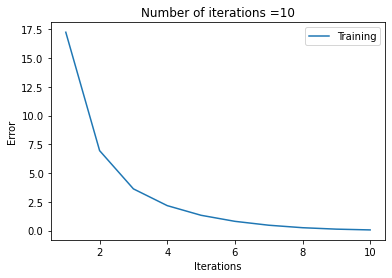

In [ ]:
def main(trainseed, testseed):
  # loading mnist and fashion mnist and normalizing 
  X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist,\
           X_train_fmnist, y_train_fmnist, X_test_fmnist, y_test_fmnist = load_dataset()
  X_train_mnist, X_test_mnist, X_train_fmnist,\
           X_test_fmnist = normalize(X_train_mnist, X_test_mnist,X_train_fmnist, X_test_fmnist)


  # flatten image vectors
  X_train_mnist_flatten = X_train_mnist.reshape(X_train_mnist.shape[0], -1)
  X_test_mnist_flatten = X_test_mnist.reshape(X_test_mnist.shape[0], -1)

  # take only the first NUM_* records
  X_train_mnist_flatten = X_train_mnist_flatten[:NUM_TRAIN, :]
  X_test_mnist_flatten = X_test_mnist_flatten[:NUM_TEST, :]
  y_train_mnist = y_train_mnist[:NUM_TRAIN, :]
  y_test_mnist = y_test_mnist[:NUM_TEST, :]

  BATCH_SIZE = 60

  # Actual training code here ->
  # Set number of epochs
  NUM_EPOCHS = 10
  # Initialize model using GPU
  mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='cpu')
  time_start = time.time()
  train_errs = []; test_errs = []

  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    total_test_loss = tf.zeros([1, 1], dtype=tf.float32)
    lt = 0
    ##############################
    # Run training for this epoch
    train_ds = tf.data.Dataset.from_tensor_slices(
                      (X_train_mnist_flatten, y_train_mnist)).shuffle(70, seed=epoch*(trainseed)).batch(BATCH_SIZE)
    diffs = 0
    cases = 0
    for inputs, outputs in train_ds:
      # forward prop.
      preds = mlp_on_gpu.forward(inputs)     
      # calc error
      loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
      lt = lt + mlp_on_gpu.loss(preds, outputs)
      # calc accuracy
      preds = tf.nn.softmax(preds)
      diffs += tf.math.reduce_sum(tf.abs(preds - outputs))
      cases += preds.shape[0]
      # backprop.
      mlp_on_gpu.backward(inputs, outputs)

    cerr = np.sum(loss_total_gpu) / X_train_mnist_flatten.shape[0]
    train_errs.append(cerr)
    diffs = (diffs/(2*cases))
    print('Number of Epoch = {}'.format(epoch + 1))
    print('Training error := {}'.format(cerr))
    print("Training accuracy: {} %".format(100 - (diffs)*100))

    ##############################
    # Run Testing
    # test_ds = tf.data.Dataset.from_tensor_slices((X_test_mnist_flatten,
    #                                                y_test_mnist)).shuffle(70, seed=epoch*(testseed)).batch(BATCH_SIZE) 
    # diffs = 0
    # cases = 0
    # for ins, outs in test_ds:
    #   preds = mlp_on_gpu.predict(ins)
    #   total_test_loss = total_test_loss + mlp_on_gpu.loss(preds, outs)
    #   # calc accuracy
    #   preds = tf.nn.softmax(preds)
    #   diffs += tf.math.reduce_sum(tf.abs(preds - outs))
    #   cases += preds.shape[0]

    # derr = np.sum(total_test_loss) / X_test_mnist_flatten.shape[0]
    # test_errs.append(derr)
    # diffs = (diffs/(2*cases))
    # print('Testing error := {}'.format(derr))
    # print("Test accuracy: {} %".format(100 - (diffs)*100))
  
  # all epochs done
  time_taken = time.time() - time_start
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

  test_ds = tf.data.Dataset.from_tensor_slices((X_test_mnist_flatten,
                                                  y_test_mnist)).shuffle(70, seed=epoch*(testseed)).batch(BATCH_SIZE) 
  diffs = 0
  cases = 0
  for ins, outs in test_ds:
    preds = mlp_on_gpu.predict(ins)
    total_test_loss = total_test_loss + mlp_on_gpu.loss(preds, outs)
    # calc accuracy
    preds = tf.nn.softmax(preds)
    diffs += tf.math.reduce_sum(tf.abs(preds - outs))
    cases += preds.shape[0]

  derr = np.sum(total_test_loss) / X_test_mnist_flatten.shape[0]
  test_errs.append(derr)
  diffs = (diffs/(2*cases))
  print('Testing error := {}'.format(derr))
  print("Test accuracy: {} %".format(100 - (diffs)*100))
  
  iters = np.arange(1, NUM_EPOCHS+1, 1)

  # Plot learning curve (with errors)
  trains = np.squeeze(train_errs)
  # tests = np.squeeze(test_errs)
  plt.plot(iters, trains)
  # plt.plot(iters, tests)
  plt.legend(["Training", "Testing"])
  plt.ylabel('Error')
  plt.xlabel('Iterations')
  plt.title("Number of iterations =" + str(NUM_EPOCHS))
  plt.show()
  

from random import seed
from random import random
seed(541010101)
trainr = int(random () * 10**5)
testr = int(random() * 10**5)
print("Rand values - ", trainr, testr)
main(trainr, testr)